<a href="https://colab.research.google.com/github/MaxCojocari/CV_camp_projects/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip -d masoudnickparvar/brain-tumor-mri-dataset

 98% 145M/149M [00:01<00:00, 126MB/s]
100% 149M/149M [00:01<00:00, 136MB/s]


In [2]:
# PyTorch
import torch
from torch import nn
from torch import optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# I want to be able to replicate the results, therefore
# I use a hard coded seed
torch.manual_seed(69)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import copy

In [3]:
 transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
train_data = ImageFolder(r'/content/drive/MyDrive/Data_ML/brain_tumor_data/Training', transform = transformations)
test_data = ImageFolder(r'/content/drive/MyDrive/Data_ML/brain_tumor_data/Testing', transform = transformations)

In [5]:
# Checking if there is a cuda compatible gpu available
cuda_available = torch.cuda.is_available()

# If cuda is available we are going to use it
# otherwise we are going to train the model on the cpu
device = (
    torch.device('cuda')
    if cuda_available
    else torch.device('cpu')
)

print(f'We are going to train the model using {device}')

We are going to train the model using cuda


In [6]:
from collections import OrderedDict

model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False
    
nr_feat = model.fc.in_features #2048
model.fc = nn.Linear(nr_feat, 4)
#model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,4)),('sigmoid',nn.Sigmoid())]))

learning_rate = 1e-3
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

#loss_fn = nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
# Defining the function that contains the training loop
def training_loop(
    n_epochs, optimizer, model, loss_fn,
    train_loader, test_loader, device
):
    # The following torch tensor will hold information about
    # the accuracy results after every epoch
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    # The actual training_loop
    for epoch in range(n_epochs):
        model.train()
        for examples, labels in train_loader:
            # Copying these tensors to the gpu ram
            # if needed
            # If a cuda compatible gpu is not available
            # the data remains on the cpu ram 
            examples = examples.to(device=device)
            labels = labels.to(device=device)

            outputs = model(examples)
            loss = loss_fn(outputs, labels)

            # Sets the gradients of all optimized torch.Tensor to zero
            optimizer.zero_grad()
            # Back Propagation
            loss.backward()
            # the optimizer updates the parameters
            optimizer.step()

        # This loop computes the accuracy for test and train data
        # after every epoch
        model.eval()
        for name, loader, accuracy in [
            ('train', train_loader, train_accuracy),
            ('test', test_loader, test_accuracy)
        ]:
            correct = 0
            total = 0

            # This with statement turns off auto grad
            with torch.no_grad():
                for examples, labels in loader:
                    examples = examples.to(device=device)
                    labels = labels.to(device=device)

                    outputs = model(examples)
                    _, predicted = torch.max(outputs, dim=1)
                    
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
            
            accuracy[epoch] = correct / total


        # This piece of code saves the models that has the best
        # test accuracy
        best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1].item())
        if best_test_accuracy:
            best_model = copy.deepcopy(model.state_dict())

        print(
            f'Epoch {epoch + 1})', 
            f'Train Accuracy: {train_accuracy[epoch]}',
            f'Test Accuracy: {test_accuracy[epoch]}',
            f'{"Best test accuracy!" if best_test_accuracy else ""}'
        )

    # Plotting the train and test accuracy after every epoch
    plt.figure(dpi=120)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.plot(range(1, n_epochs + 1), train_accuracy)
    plt.plot(range(1, n_epochs + 1), test_accuracy)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.grid()
    plt.show()

    return best_model

In [8]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1) Train Accuracy: 0.6509103775024414 Test Accuracy: 0.6468344926834106 Best test accuracy!
Epoch 2) Train Accuracy: 0.6530112028121948 Test Accuracy: 0.6681922078132629 Best test accuracy!
Epoch 3) Train Accuracy: 0.9593837261199951 Test Accuracy: 0.9328756928443909 Best test accuracy!
Epoch 4) Train Accuracy: 0.9560574293136597 Test Accuracy: 0.9252479076385498 
Epoch 5) Train Accuracy: 0.894957959651947 Test Accuracy: 0.8642258048057556 
Epoch 6) Train Accuracy: 0.7190126180648804 Test Accuracy: 0.6933638453483582 
Epoch 7) Train Accuracy: 0.8786764740943909 Test Accuracy: 0.8588863611221313 
Epoch 8) Train Accuracy: 0.8764005899429321 Test Accuracy: 0.8474447131156921 
Epoch 9) Train Accuracy: 0.9856442809104919 Test Accuracy: 0.9610983729362488 Best test accuracy!
Epoch 10) Train Accuracy: 0.9879201650619507 Test Accuracy: 0.9610983729362488 


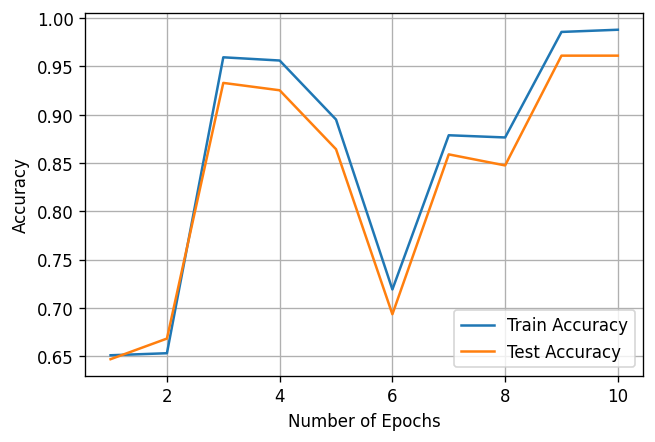

In [11]:
# Training the model
best_model = training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

In [12]:
# Load the model that had the best test accuracy
model.load_state_dict(best_model)

<All keys matched successfully>

In [14]:
correct = 0
total = 0

y_test = torch.zeros(len(test_data))
y_pred = torch.zeros(len(test_data))
low = 0

# Make predictions on the test data
model.eval()
with torch.no_grad():
    for examples, labels in test_loader:
        examples = examples.to(device=device)
        labels = labels.to(device=device)

        outputs = model(examples)
        _, predicted = torch.max(outputs, dim=1)

        high = low + labels.shape[0]
        y_test[low : high] = labels
        y_pred[low : high] = predicted
        low = high

        total += labels.shape[0]
        correct += int((predicted == labels).sum())
            
accuracy = correct / total
accuracy

0.9610983981693364

Text(0.5, 32.08333333333333, 'Predicted Label')

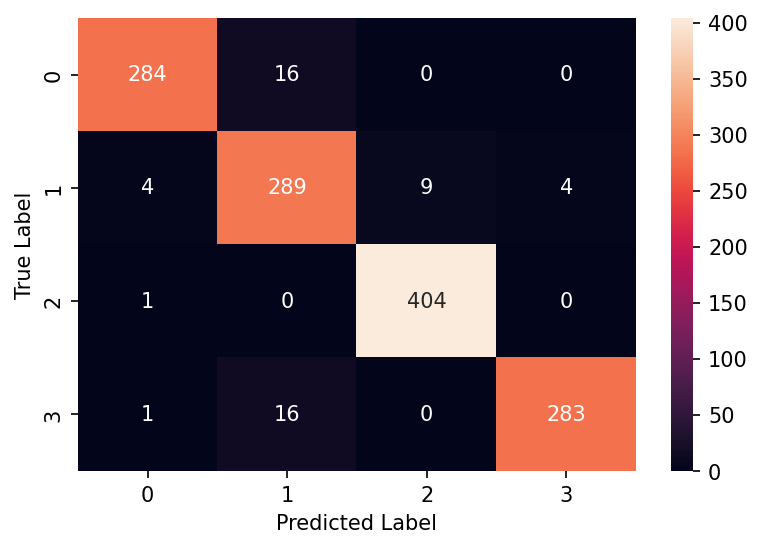

In [15]:
# Creating a Confusion Matrix plot
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')